Importing libraries and defining stimulus arrays simulations. There are three stimulus arrays reprenting shifts from 500 ms ISI to 510 ms, 520 ms, and 550 ms, which correspond to figures 4, 2, and 3 from the Thaut paper on tempo shifts.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

The neural network model of parallel CSNTC loops:

In [69]:
class b_ganglia:
    def __init__(self,n_loops,time_steps):

        self.n_loops = n_loops
        self.n_steps = time_steps
        exc_spread = 15

        #matrix to hold activations for all layers
        self.a_sd1 = np.zeros((time_steps, n_loops))
        self.a_sd2 = np.zeros((time_steps, n_loops))
        self.a_stn = np.zeros((time_steps, n_loops))
        self.a_gpi = np.ones((time_steps, n_loops))
        self.a_gpe = np.zeros((time_steps, n_loops))
        self.a_tha = np.zeros((time_steps, n_loops))
        self.a_ctx = np.zeros((time_steps, n_loops))

        #vector to hold changing dopamine levels
        self.da = np.ones((time_steps))

        #matrix to hold the inputs to each unit
        self.a_input = np.zeros((time_steps, n_loops))


        #variable to keep track of what step we are currently on
        self.c = 0

        ####               weights connecting all the layers    #####

        #cortico-striatal connections are topographical, but also overlapping, thus we will use the Guassians we have previously shown work
        #first change from the original version, we will not have "input"-striatum connections, we will have a single cortical layer at the top receiving both "input" and thalamic input

        #initializing the matrices to hold all the weights
        self.w_ctx_sd1 = np.zeros((n_loops,n_loops))
        self.w_ctx_sd2 = np.zeros((n_loops,n_loops))


        #the weights from input to the cortex will just be the identity matrix I think
        self.w_inp_ctx = np.identity(n_loops) * 0.32


        unit_ids = np.arange(0,n_loops,1)        
        for i in range(0,n_loops):
            #inserting the Guassians into the matrix
            #wider-spreading connectivities
            self.w_ctx_sd1[i] = stats.norm.pdf(unit_ids, i, exc_spread) / np.max(stats.norm.pdf(unit_ids, i, exc_spread)) * 0.04 #the dividing by the max ensure the weight distribution has a max of 1 before any other changes, just keeps the weights reasonable I think
            self.w_ctx_sd2[i] = stats.norm.pdf(unit_ids, i, exc_spread) / np.max(stats.norm.pdf(unit_ids, i, exc_spread)) * 0.04

        #second attempt at this, implementing pure 1-to-1 connectivity
        self.w_ctx_stn = np.identity(n_loops) * 1
        self.w_sd1_gpi = np.identity(n_loops) * -1.5
        self.w_sd2_gpe = np.identity(n_loops) * -1.5
        self.w_gpe_stn = np.identity(n_loops) * -0.5
        self.w_gpe_gpi = np.identity(n_loops) * -0.01
        self.w_gpi_tha = np.identity(n_loops) * -1.2
        self.w_tha_ctx = np.identity(n_loops) * 1.2

        #the STN has dense connectivity to the output nuclei so we can just set these as an array of ones
        self.w_stn_gpi = np.ones((self.n_loops,self.n_loops)) * 0.01
        self.w_stn_gpe = np.ones((self.n_loops,self.n_loops)) * 0.01 



    #uses euler integration to calculate the activation at each unit in the model of the basal ganglia 
    def run(self, means, dopamine):

        #likely easier to just define the parameters inside this function...
        dt = 0.0001
        tau = 0.01
        #time constant 
        h= dt/tau
        unit_ids = np.arange(0,300,1) #this is used to define the input to the attractor later


        #define the sensitivies to dopamine and normal response
        sd1_bl = 0.7
        sd1_DA = 0.35
        sd2_bl = 1
        sd2_DA = 8

        self.da = dopamine

        tap_count = 0
        #eulers method
        for i in range(self.n_steps-1):

            if i % 5000 == 0:
                #determining the input to the top of the network based on last observed ISI
                self.a_input[i:i+750] = stats.norm.pdf(unit_ids, means[tap_count], 15) / np.max(stats.norm.pdf(unit_ids, means[tap_count], 15))
                tap_count += 1 

            #vector containing abstract representation of activity in different cortical areas, receives user determined input, and connections from the thalamus
            self.a_ctx[i+1] = self.a_ctx[i] + h * (self.non_lin(np.matmul(self.a_input[i], self.w_inp_ctx) + np.matmul(self.a_tha[i], self.w_tha_ctx)) - self.a_ctx[i])
        
            #input to direct pathway of striatum, cortical input modulated by dopamine
            self.a_sd1[i+1] = self.a_sd1[i] + h * (self.non_lin((sd1_bl + sd1_DA * self.da[i]) * np.matmul(self.a_ctx[i], self.w_ctx_sd1)) - self.a_sd1[i])

            #input to sd2 modulated by dopamine
            self.a_sd2[i+1] = self.a_sd2[i] + h * (self.non_lin( (1/(sd2_bl + sd2_DA * self.da[i])) * np.matmul(self.a_ctx[i], self.w_ctx_sd2)) - self.a_sd2[i]) 

            #input to stn from ctx and gpe
            self.a_stn[i+1] = self.a_stn[i] + h * (self.non_lin(np.matmul(self.a_ctx[i], self.w_ctx_stn) + np.matmul(self.a_gpe[i], self.w_gpe_stn) + 0.3) - self.a_stn[i])

            #input to gpe from stn and sd2
            self.a_gpe[i+1] = self.a_gpe[i] + h * (self.non_lin(np.matmul(self.a_sd2[i], self.w_sd2_gpe) + np.matmul(self.a_stn[i], self.w_stn_gpe) + 0.4) - self.a_gpe[i])

            #input to gpi from strd1, stn, and gpe 
            self.a_gpi[i+1] = self.a_gpi[i] + h * (self.non_lin(np.matmul(self.a_sd1[i], self.w_sd1_gpi) + np.matmul(self.a_stn[i], self.w_stn_gpi) + np.matmul(self.a_gpe[i], self.w_gpe_gpi) + 0.8) - self.a_gpi[i])

            #input to thalamus from gpi 
            self.a_tha[i+1] = self.a_tha[i] + h * (self.non_lin(np.matmul(self.a_gpi[i], self.w_gpi_tha) + 0.8) - self.a_tha[i])


        self.saliences = np.argmax(self.a_tha[1000:-1], axis=1)

        return None

    #non-linearity to generate activations
    def non_lin(self,vec):

        #apply non-linearity
        x = np.tanh(vec)
        
        #set any negative values to 0
        for i in range(self.n_loops):
            if x[i] < 0:
                x[i] = 0
        
        return x


    def display(self):

        titles = ('Input','Ctx', 'SD1', 'SD2', "STN", "GPi/SNpr", "GPe", "Tha")
        data = (self.a_input,  self.a_ctx, self.a_sd1, self.a_sd2, self.a_stn, self.a_gpi, self.a_gpe, self.a_tha)

        fig, ax = plt.subplots(9)
        fig.set_figheight(20)
        fig.set_figwidth(15)
        fig.tight_layout()

        ax[0].plot(self.da[20:140000])
        ax[0].set_title("Dopamine levels")

        for i in range(1,9):
            im = ax[i].imshow(data[i-1][20:140000].T,aspect='auto')
            ax[i].set_title(str(titles[i-1]+ ' layer activations'))
            plt.colorbar(im, ax=ax[i])
        
        #this code plots the activations of all units at different time steps for each layer, it can be helpful for diagnosing problems but also takes a long time to plot and doesn't provide a ton of
        # new information, so we can leave it commented out for now
        '''
        fig2, ax = plt.subplots(8)
        fig2.set_figheight(20)
        fig2.set_figwidth(15)
        fig2.tight_layout()

        #this code plots the activations of all units at different time steps for each layer, it can be helpful for diagnosing problems but also takes a long time to plot and doesn't provide a ton of
        # new information, so we can leave it commented out for now
        
        for i in range(8):
            time_steps = np.arange(5000,self.n_steps,5000)
            for step in time_steps:
                ax[i].plot(data[i][step + 500],alpha=0.5,label= str("step = "+str(step)))
                ax[i].set_title(titles[i])
                #ax[i].legend()
        '''

        return None

#simulates an Ornstein-Uhlenbeck process
def OU(steps):
    N = steps   #time steps
    kappa = 0.3 #mean revision constant
    theta = 0 #long term mean
    sigma = 0.5 #volatility constant (how much noise there is?)

    dt = 0.001

    X= np.zeros(N)
    X[0] = 0

    W = stats.norm.rvs(loc=0, scale=1, size=(N - 1, 1)) #W is the Wiener process, I think this is just the actual random noise

    std_dt = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
    for t in range(0, N - 1):
        X[t + 1] = theta + np.exp(-kappa * dt) * (X[t] - theta) + std_dt * W[t]
    return X


Define a neural network and simulate the response to a shift in ISIs from 500 ms to 510 ms:

C:\Users\Jacob\AppData\Local\Temp\ipykernel_22320\3529605860.py:193: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[t + 1] = theta + np.exp(-kappa * dt) * (X[t] - theta) + std_dt * W[t]


149.85731390693226
151.2533536754674
151.20417464977706
153.6198036435555
154.95480619717915
160.1679360767637
162.09671016063075
159.25641222455707
161.53213254132928
161.83459345145337
153.5177252804861
155.37057392173912
155.5614303245738
158.4742218191517
161.73859947267295
165.35529775670244
172.30078114851892
177.0534944293239
181.2907296677116
183.3924536834155
182.5067397299785
179.7758373646575
176.87442680103763
177.0531153302971
179.2628022905345
175.8609700007916
177.21328650928388
177.379491649201
180.07528695351664
181.27245804833282
179.25697010098446
177.76487923464066
176.8591950842037
174.0733759034192
168.83911635845712
168.36843778158592
167.78005582092436
159.99866751240407
155.58759649614979
157.46399488048496
155.96694946344192
156.13272358191034
153.23155397664533
155.0741343652292
151.57271356854653
149.88280224653613
146.5471724793269
146.96428539086665
142.3324995783869


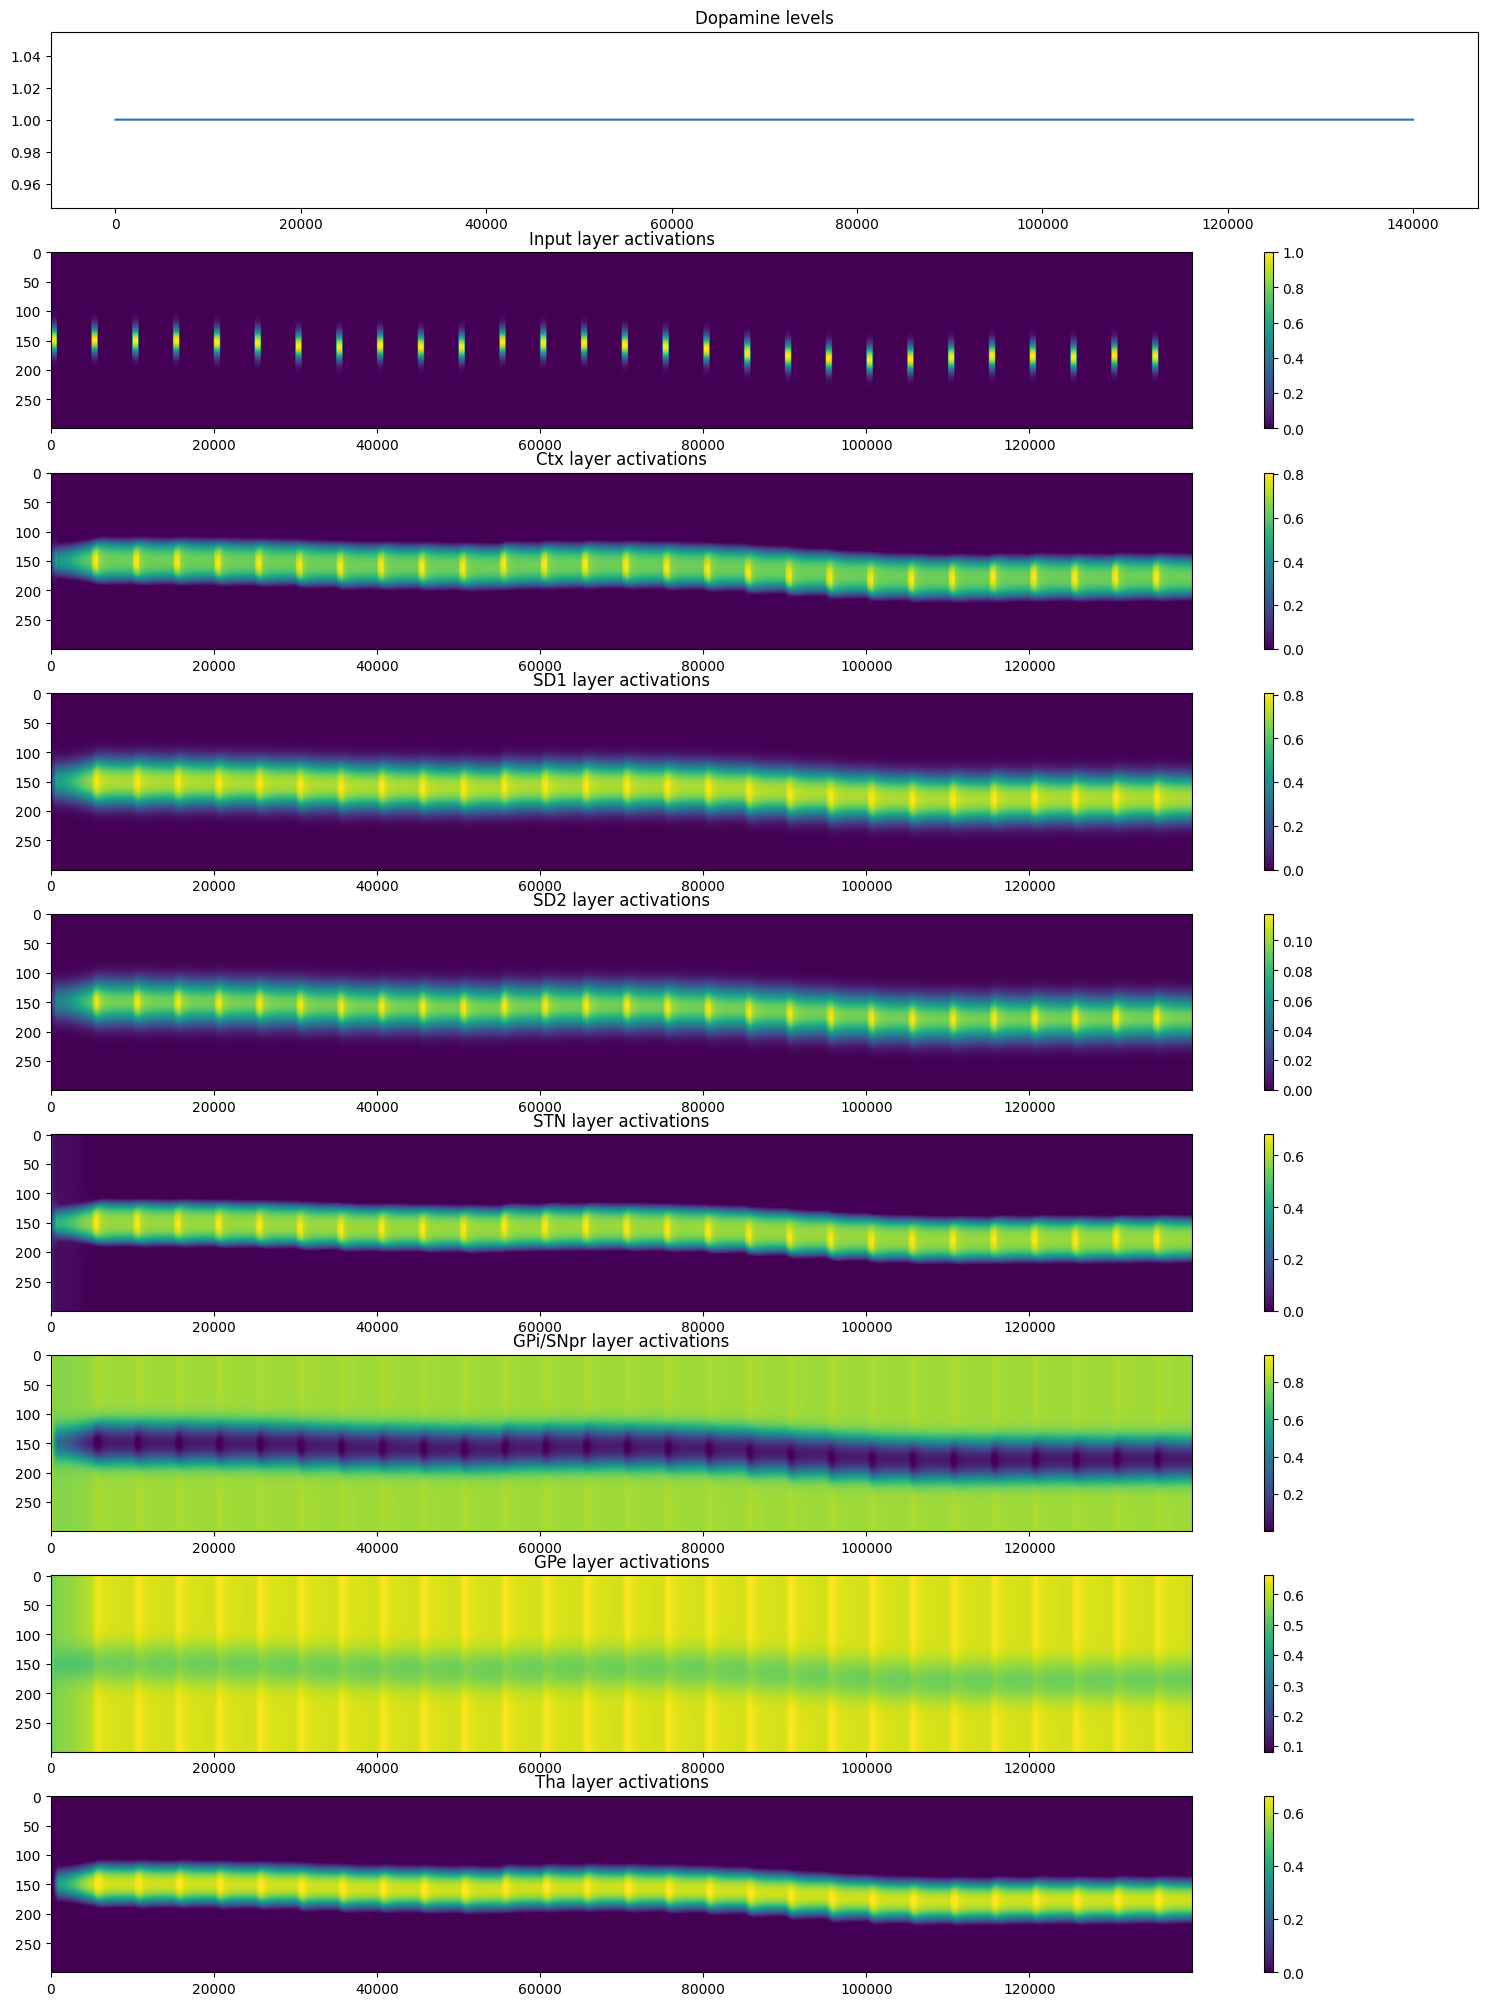

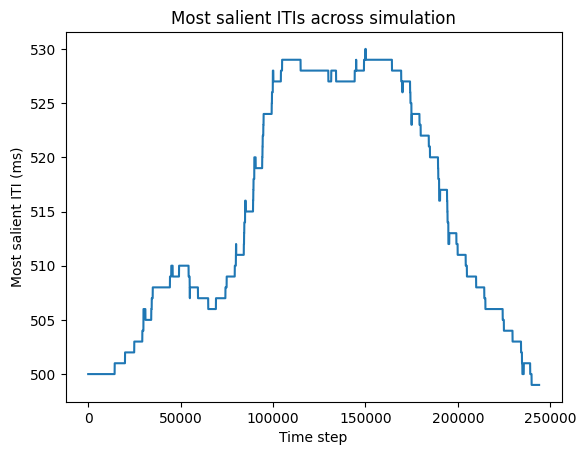

In [44]:
bg1 = b_ganglia(n_loops=300, time_steps=245000)
dopamine = np.ones(245000)
means = noise = OU(50) * 200 + 150

bg1.run(means, dopamine)
bg1.display()


C:\Users\Jacob\AppData\Local\Temp\ipykernel_22320\1821140572.py:186: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[t + 1] = theta + np.exp(-kappa * dt) * (X[t] - theta) + std_dt * W[t]


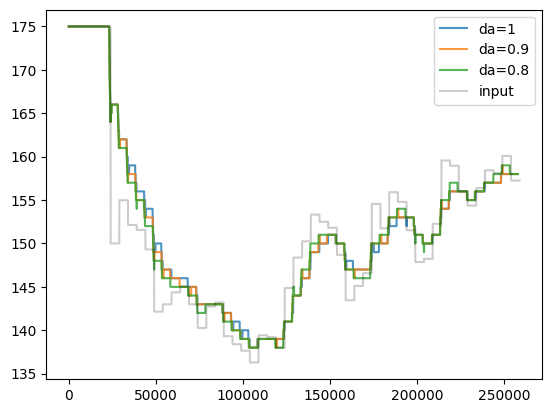

In [73]:
means = OU(50) * 200 + 150
means = np.concatenate((np.ones(5) * 250, means))
disp_means = np.zeros(260000)

for i in range(len(means)):
    j = i * 5000
    disp_means[j:j+5000] = means[i]


bg1 = b_ganglia(n_loops=300, time_steps=260000)
dop = np.ones(260000)
bg1.run(means, dop)


bg2 = b_ganglia(n_loops=300, time_steps=260000)
dop = np.ones(260000)
dop[25000:] = 0.9
bg2.run(means, dop)


bg3 = b_ganglia(n_loops=300, time_steps=260000)
dop = np.ones(260000)
dop[25000:] = 0.8
bg3.run(means, dop)

plt.plot(bg1.saliences[1000:-1], label="da=1",alpha=0.8)
plt.plot(bg2.saliences[1000:-1], label="da=0.9",alpha=0.8)
plt.plot(bg3.saliences[1000:-1], label="da=0.8",alpha=0.8)

plt.plot(disp_means[1000:-1], label="input",alpha=0.2,color="black")
plt.legend()


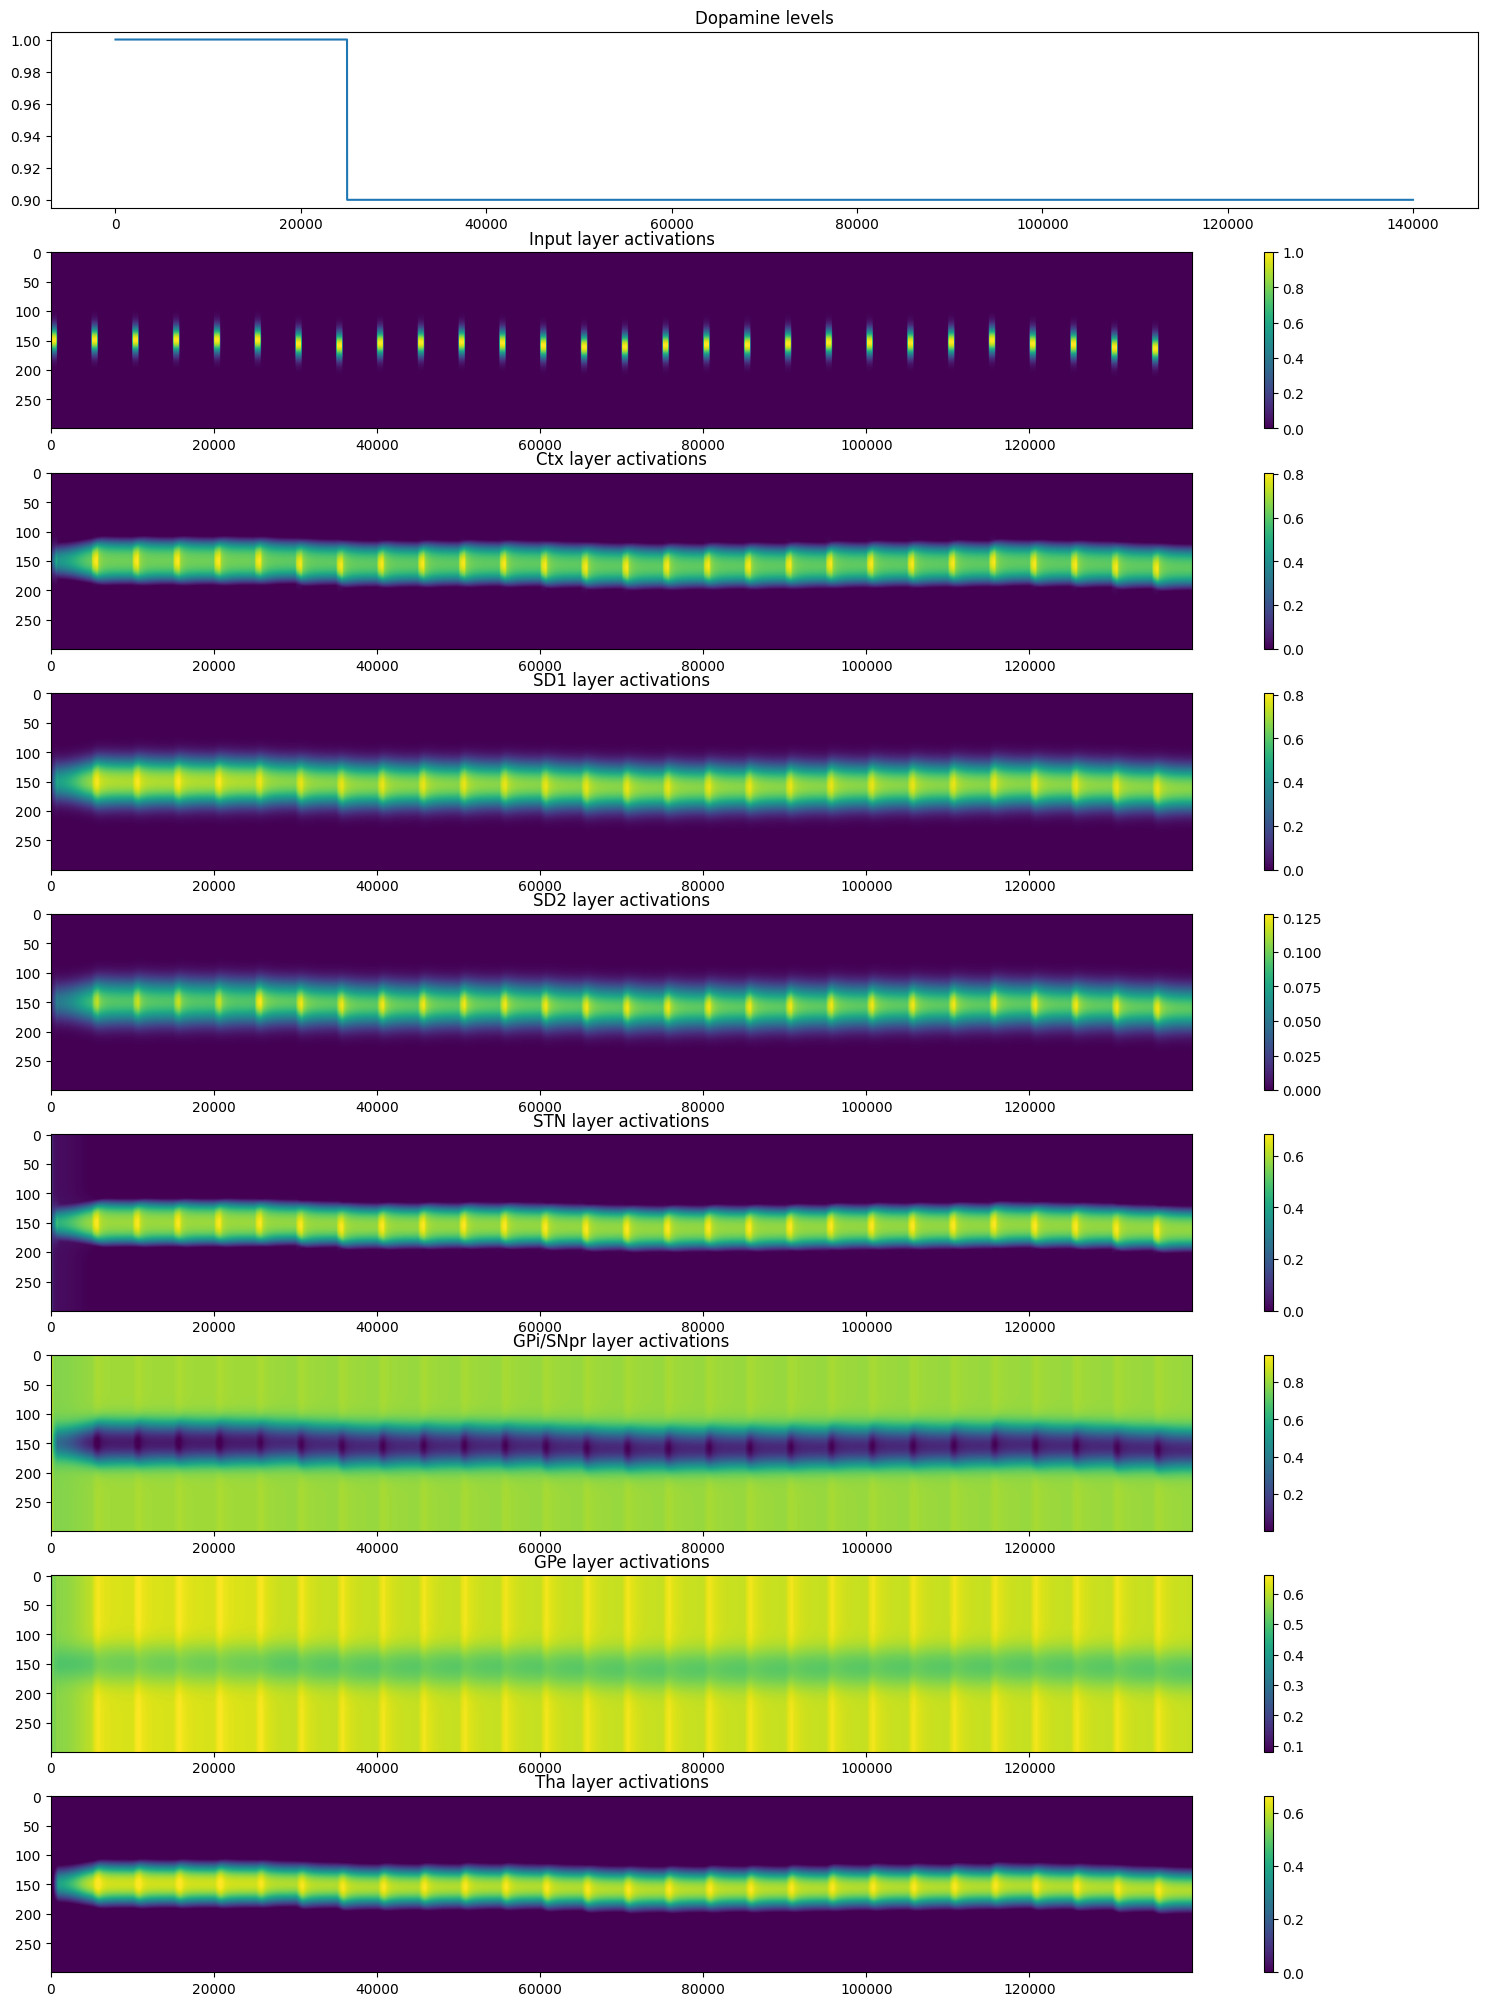

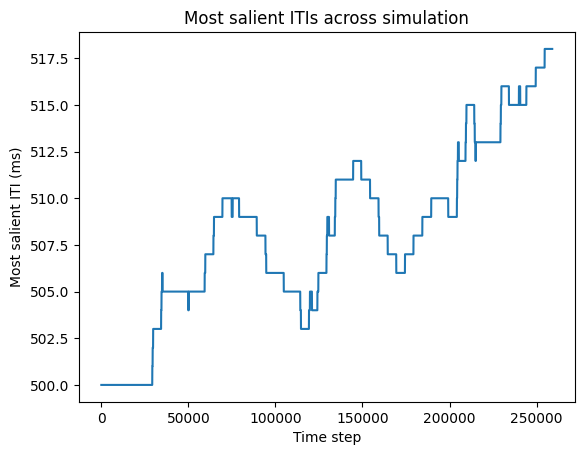

In [66]:
bg2.display()

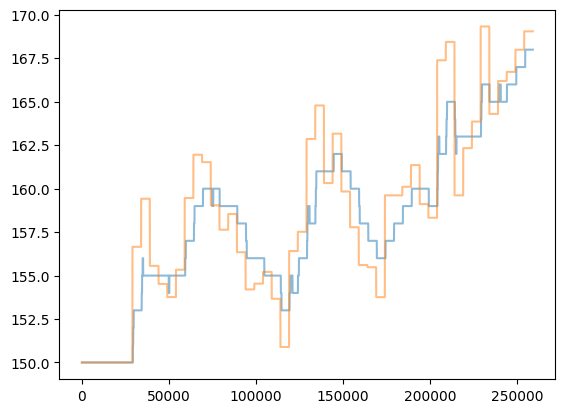

In [67]:
disp_means = np.zeros(260000)

for i in range(len(means)):
    j = i * 5000
    disp_means[j:j+5000] = means[i]

#plt.plot(bg2.saliences[1000:-1]-350,alpha=0.5)
plt.plot(disp_means[1000:-1],alpha=0.5)

In [56]:
disp_means = np.zeros(260000)

for i in range(len(means)):
    j = i * 5000
    disp_means[j:j+5000] = means[i]

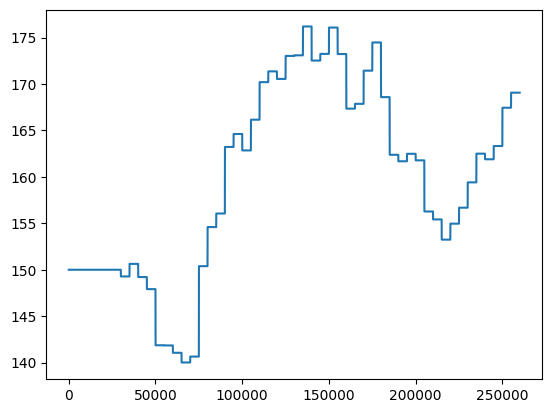

In [57]:
plt.plot(disp_means)